# High order contamination study for HD205905


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [1]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [2]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [4]:
from scipy import interpolate

In [5]:
import seaborn as sns

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Figure style

In [7]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [8]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [9]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../../merra2'

In [10]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [11]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [12]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [13]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [14]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [15]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [16]:
home=os.getenv('HOME')

In [17]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [18]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [19]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [20]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [21]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [22]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [23]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [24]:
# laptop:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2')

In [25]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2'

## Selection of night

In [26]:
date="20170608"

In [27]:
idx_sel_subdir=9

In [28]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [29]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [30]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [31]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [32]:
wlshift.head()

,index,wlshift
0,4,0.0
1,5,2.0
2,7,2.0
3,8,1.0
4,9,5.0


### path for spectra

In [33]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [34]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [35]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [36]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [37]:
sel_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-09T00:23:03.951,4,784,"5,6",0,"1,021","0,962",60,HD111980,FGB37,Ron200,12450,"15,2",data_08jun17,reduc_20170608_004.fits
2017-06-09T00:24:57.006,5,784,"5,6",0,"1,021","0,962",60,HD111980,RG715,Ron200,12450,"14,5",data_08jun17,reduc_20170608_005.fits
2017-06-09T00:26:53.450,6,784,"5,5",0,"1,021","0,962",60,HD111980,FGB37,Thor300,12450,"14,2",data_08jun17,reduc_20170608_006.fits
2017-06-09T00:28:47.905,7,784,"5,5",0,"1,021","0,962",60,HD111980,RG715,Thor300,12450,13,data_08jun17,reduc_20170608_007.fits
2017-06-09T00:30:44.403,8,784,"5,5",0,"1,021","0,962",60,HD111980,FGB37,HoloPhP,12450,"14,7",data_08jun17,reduc_20170608_008.fits


In [38]:
sel_obs.tail()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-09T10:32:32.106,353,783,"8,6",31,"1,051","0,962",30,HD205905,RG715,HoloAmAg,12450,"9,6",data_08jun17,reduc_20170608_353.fits
2017-06-09T10:33:58.007,354,783,"8,6",35,"1,053","0,962",15,HD205905,FGB37,Ron200,12450,7,data_08jun17,reduc_20170608_354.fits
2017-06-09T10:35:07.405,355,783,"8,6",0,"1,055","0,962",15,HD205905,RG715,Ron200,12450,"6,5",data_08jun17,reduc_20170608_355.fits
2017-06-09T10:36:16.849,356,783,"8,7",0,"1,056","0,962",15,HD205905,FGB37,Thor300,12450,"13,4",data_08jun17,reduc_20170608_356.fits
2017-06-09T10:37:26.304,357,783,"8,6",0,"1,058","0,962",15,HD205905,RG715,Thor300,12450,"7,6",data_08jun17,reduc_20170608_357.fits


### Quick view on the kind of sources

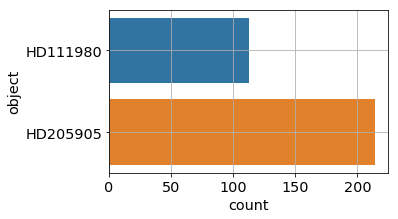

In [39]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

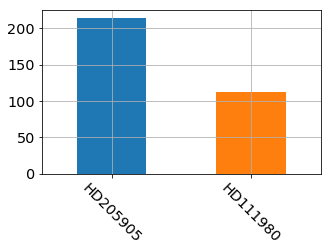

In [40]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectra

In [41]:
bad_calib_indexes=np.array([6,16,23,26,36,46,56,66,76,86,96,106,116])

In [42]:
file_toremove=[]
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_calib_indexes:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f) 

 remove  reduc_20170608_006_spectrum.fits
 remove  reduc_20170608_016_spectrum.fits
 remove  reduc_20170608_023_spectrum.fits
 remove  reduc_20170608_026_spectrum.fits
 remove  reduc_20170608_036_spectrum.fits
 remove  reduc_20170608_046_spectrum.fits
 remove  reduc_20170608_056_spectrum.fits
 remove  reduc_20170608_066_spectrum.fits
 remove  reduc_20170608_076_spectrum.fits
 remove  reduc_20170608_086_spectrum.fits
 remove  reduc_20170608_096_spectrum.fits
 remove  reduc_20170608_106_spectrum.fits
 remove  reduc_20170608_116_spectrum.fits


### Remove bad sources

- remove star **'PKS1510-089'**

In [43]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6','HD111980'])]
bad_indexes=bad_obs["index"]

In [44]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-09T00:23:03.951,4,784,"5,6",0,"1,021","0,962",60,HD111980,FGB37,Ron200,12450,"15,2",data_08jun17,reduc_20170608_004.fits
2017-06-09T00:24:57.006,5,784,"5,6",0,"1,021","0,962",60,HD111980,RG715,Ron200,12450,"14,5",data_08jun17,reduc_20170608_005.fits
2017-06-09T00:26:53.450,6,784,"5,5",0,"1,021","0,962",60,HD111980,FGB37,Thor300,12450,"14,2",data_08jun17,reduc_20170608_006.fits
2017-06-09T00:28:47.905,7,784,"5,5",0,"1,021","0,962",60,HD111980,RG715,Thor300,12450,13,data_08jun17,reduc_20170608_007.fits
2017-06-09T00:30:44.403,8,784,"5,5",0,"1,021","0,962",60,HD111980,FGB37,HoloPhP,12450,"14,7",data_08jun17,reduc_20170608_008.fits
2017-06-09T00:32:38.600,9,784,"5,5",0,"1,021","0,962",60,HD111980,RG715,HoloPhP,12450,"14,5",data_08jun17,reduc_20170608_009.fits
2017-06-09T00:34:34.508,10,784,"5,6",0,"1,021","0,962",120,HD111980,FGB37,HoloPhAg,12450,"10,4",data_08jun17,reduc_20170608_010.fits
2017-06-09T00:37:28.704,11,784,0,0,"1,022","0,962",120,HD111980,RG715,HoloPhAg,12450,"10,5",data_08jun17,reduc_20170608_011.fits
2017-06-09T00:40:25.057,12,784,0,0,"1,022","0,962",120,HD111980,FGB37,HoloAmAg,12450,"13,1",data_08jun17,reduc_20170608_012.fits


In [45]:
bad_indexes=bad_obs.loc[:,"index"]

In [46]:
bad_indexes.index

Index([u'2017-06-09T00:23:03.951', u'2017-06-09T00:24:57.006',
       u'2017-06-09T00:26:53.450', u'2017-06-09T00:28:47.905',
       u'2017-06-09T00:30:44.403', u'2017-06-09T00:32:38.600',
       u'2017-06-09T00:34:34.508', u'2017-06-09T00:37:28.704',
       u'2017-06-09T00:40:25.057', u'2017-06-09T00:43:19.205',
       ...
       u'2017-06-09T04:19:48.802', u'2017-06-09T04:21:43.203',
       u'2017-06-09T04:23:37.501', u'2017-06-09T04:25:33.343',
       u'2017-06-09T04:28:27.704', u'2017-06-09T04:31:22.104',
       u'2017-06-09T04:34:16.501', u'2017-06-09T04:37:11.800',
       u'2017-06-09T04:39:06.202', u'2017-06-09T04:41:00.599'],
      dtype='object', name=u'date', length=113)

In [47]:
bad_indexes.values

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116])

### Concatenate bad obs

In [48]:
#bad_obs=pd.concat([bad_obs,bad_obs_0])

In [49]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-06-09T00:23:03.951,4,784,"5,6",0,"1,021","0,962",60,HD111980,FGB37,Ron200,12450,"15,2",data_08jun17,reduc_20170608_004.fits
2017-06-09T00:24:57.006,5,784,"5,6",0,"1,021","0,962",60,HD111980,RG715,Ron200,12450,"14,5",data_08jun17,reduc_20170608_005.fits
2017-06-09T00:26:53.450,6,784,"5,5",0,"1,021","0,962",60,HD111980,FGB37,Thor300,12450,"14,2",data_08jun17,reduc_20170608_006.fits
2017-06-09T00:28:47.905,7,784,"5,5",0,"1,021","0,962",60,HD111980,RG715,Thor300,12450,13,data_08jun17,reduc_20170608_007.fits
2017-06-09T00:30:44.403,8,784,"5,5",0,"1,021","0,962",60,HD111980,FGB37,HoloPhP,12450,"14,7",data_08jun17,reduc_20170608_008.fits
2017-06-09T00:32:38.600,9,784,"5,5",0,"1,021","0,962",60,HD111980,RG715,HoloPhP,12450,"14,5",data_08jun17,reduc_20170608_009.fits
2017-06-09T00:34:34.508,10,784,"5,6",0,"1,021","0,962",120,HD111980,FGB37,HoloPhAg,12450,"10,4",data_08jun17,reduc_20170608_010.fits
2017-06-09T00:37:28.704,11,784,0,0,"1,022","0,962",120,HD111980,RG715,HoloPhAg,12450,"10,5",data_08jun17,reduc_20170608_011.fits
2017-06-09T00:40:25.057,12,784,0,0,"1,022","0,962",120,HD111980,FGB37,HoloAmAg,12450,"13,1",data_08jun17,reduc_20170608_012.fits


In [50]:
bad_obs.sort_values(by="index",inplace=True)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
bad_indexes=bad_obs.loc[:,"index"]

In [52]:
bad_indexes.index

Index([u'2017-06-09T00:23:03.951', u'2017-06-09T00:24:57.006',
       u'2017-06-09T00:26:53.450', u'2017-06-09T00:28:47.905',
       u'2017-06-09T00:30:44.403', u'2017-06-09T00:32:38.600',
       u'2017-06-09T00:34:34.508', u'2017-06-09T00:37:28.704',
       u'2017-06-09T00:40:25.057', u'2017-06-09T00:43:19.205',
       ...
       u'2017-06-09T04:19:48.802', u'2017-06-09T04:21:43.203',
       u'2017-06-09T04:23:37.501', u'2017-06-09T04:25:33.343',
       u'2017-06-09T04:28:27.704', u'2017-06-09T04:31:22.104',
       u'2017-06-09T04:34:16.501', u'2017-06-09T04:37:11.800',
       u'2017-06-09T04:39:06.202', u'2017-06-09T04:41:00.599'],
      dtype='object', name=u'date', length=113)

In [53]:
bad_indexes.values

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116])

- keep stars **HD185975**

In [54]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD205905'])]

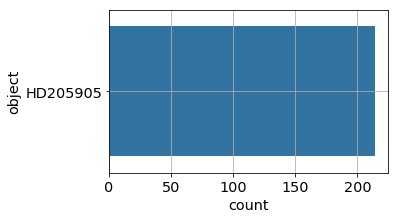

In [55]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [56]:
list_of_objects=sel2_obs['object'].values

In [57]:
list_of_objects=set(list_of_objects)

In [58]:
list_of_objects=list(list_of_objects)

In [59]:
list_of_objects_str=','.join(list_of_objects)

### find filename for sim spectra

In [60]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [61]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [62]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_08jun17/clearsky/specsim_20170608_004_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_08jun17/clearsky/specsim_20170608_005_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_08jun17/clearsky/specsim_20170608_006_spectrum.fits']

In [63]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [64]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_08jun17/standard/specsim_20170608_004_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_08jun17/standard/specsim_20170608_005_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_08jun17/standard/specsim_20170608_006_spectrum.fits']

In [65]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [66]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_08jun17/merra2/specsim_20170608_004_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_08jun17/merra2/specsim_20170608_005_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_08jun17/merra2/specsim_20170608_006_spectrum.fits']

# Remove bad indexes

In [67]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170608_004_spectrum.fits
 remove  reduc_20170608_005_spectrum.fits
 remove  reduc_20170608_007_spectrum.fits
 remove  reduc_20170608_008_spectrum.fits
 remove  reduc_20170608_009_spectrum.fits
 remove  reduc_20170608_010_spectrum.fits
 remove  reduc_20170608_011_spectrum.fits
 remove  reduc_20170608_012_spectrum.fits
 remove  reduc_20170608_013_spectrum.fits
 remove  reduc_20170608_014_spectrum.fits
 remove  reduc_20170608_015_spectrum.fits
 remove  reduc_20170608_017_spectrum.fits
 remove  reduc_20170608_018_spectrum.fits
 remove  reduc_20170608_019_spectrum.fits
 remove  reduc_20170608_020_spectrum.fits
 remove  reduc_20170608_021_spectrum.fits
 remove  reduc_20170608_022_spectrum.fits
 remove  reduc_20170608_024_spectrum.fits
 remove  reduc_20170608_025_spectrum.fits
 remove  reduc_20170608_027_spectrum.fits
 remove  reduc_20170608_028_spectrum.fits
 remove  reduc_20170608_029_spectrum.fits
 remove  reduc_20170608_030_spectrum.fits
 remove  reduc_20170608_031_spectr

In [68]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

 remove  specsim_20170608_004_spectrum.fits
 remove  specsim_20170608_005_spectrum.fits
 remove  specsim_20170608_006_spectrum.fits
 remove  specsim_20170608_007_spectrum.fits
 remove  specsim_20170608_008_spectrum.fits
 remove  specsim_20170608_009_spectrum.fits
 remove  specsim_20170608_010_spectrum.fits
 remove  specsim_20170608_011_spectrum.fits
 remove  specsim_20170608_012_spectrum.fits
 remove  specsim_20170608_013_spectrum.fits
 remove  specsim_20170608_014_spectrum.fits
 remove  specsim_20170608_015_spectrum.fits
 remove  specsim_20170608_016_spectrum.fits
 remove  specsim_20170608_017_spectrum.fits
 remove  specsim_20170608_018_spectrum.fits
 remove  specsim_20170608_019_spectrum.fits
 remove  specsim_20170608_020_spectrum.fits
 remove  specsim_20170608_021_spectrum.fits
 remove  specsim_20170608_022_spectrum.fits
 remove  specsim_20170608_023_spectrum.fits
 remove  specsim_20170608_024_spectrum.fits
 remove  specsim_20170608_025_spectrum.fits
 remove  specsim_20170608_026_sp

In [69]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

 remove  specsim_20170608_004_spectrum.fits
 remove  specsim_20170608_005_spectrum.fits
 remove  specsim_20170608_006_spectrum.fits
 remove  specsim_20170608_007_spectrum.fits
 remove  specsim_20170608_008_spectrum.fits
 remove  specsim_20170608_009_spectrum.fits
 remove  specsim_20170608_010_spectrum.fits
 remove  specsim_20170608_011_spectrum.fits
 remove  specsim_20170608_012_spectrum.fits
 remove  specsim_20170608_013_spectrum.fits
 remove  specsim_20170608_014_spectrum.fits
 remove  specsim_20170608_015_spectrum.fits
 remove  specsim_20170608_016_spectrum.fits
 remove  specsim_20170608_017_spectrum.fits
 remove  specsim_20170608_018_spectrum.fits
 remove  specsim_20170608_019_spectrum.fits
 remove  specsim_20170608_020_spectrum.fits
 remove  specsim_20170608_021_spectrum.fits
 remove  specsim_20170608_022_spectrum.fits
 remove  specsim_20170608_023_spectrum.fits
 remove  specsim_20170608_024_spectrum.fits
 remove  specsim_20170608_025_spectrum.fits
 remove  specsim_20170608_026_sp

In [70]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

 remove  specsim_20170608_004_spectrum.fits
 remove  specsim_20170608_005_spectrum.fits
 remove  specsim_20170608_006_spectrum.fits
 remove  specsim_20170608_007_spectrum.fits
 remove  specsim_20170608_008_spectrum.fits
 remove  specsim_20170608_009_spectrum.fits
 remove  specsim_20170608_010_spectrum.fits
 remove  specsim_20170608_011_spectrum.fits
 remove  specsim_20170608_012_spectrum.fits
 remove  specsim_20170608_013_spectrum.fits
 remove  specsim_20170608_014_spectrum.fits
 remove  specsim_20170608_015_spectrum.fits
 remove  specsim_20170608_016_spectrum.fits
 remove  specsim_20170608_017_spectrum.fits
 remove  specsim_20170608_018_spectrum.fits
 remove  specsim_20170608_019_spectrum.fits
 remove  specsim_20170608_020_spectrum.fits
 remove  specsim_20170608_021_spectrum.fits
 remove  specsim_20170608_022_spectrum.fits
 remove  specsim_20170608_023_spectrum.fits
 remove  specsim_20170608_024_spectrum.fits
 remove  specsim_20170608_025_spectrum.fits
 remove  specsim_20170608_026_sp

# which filters

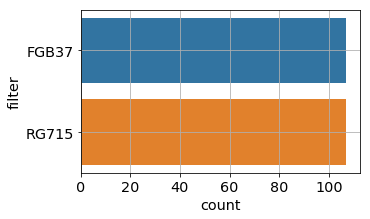

In [71]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

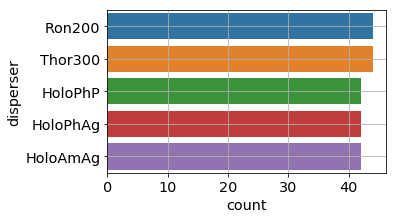

In [72]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [73]:
sel_obs_Ron200=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron200']) & sel2_obs['filter'].isin(['FGB37'])]

In [74]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300']) & sel2_obs['filter'].isin(['FGB37'])]

In [75]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP']) & sel2_obs['filter'].isin(['FGB37'])]

In [76]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg']) & sel2_obs['filter'].isin(['FGB37'])]

In [77]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg']) & sel2_obs['filter'].isin(['FGB37'])]

# Show the spectra

## Show the reconstructed spectra

In [78]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170608_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [79]:
thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi200"

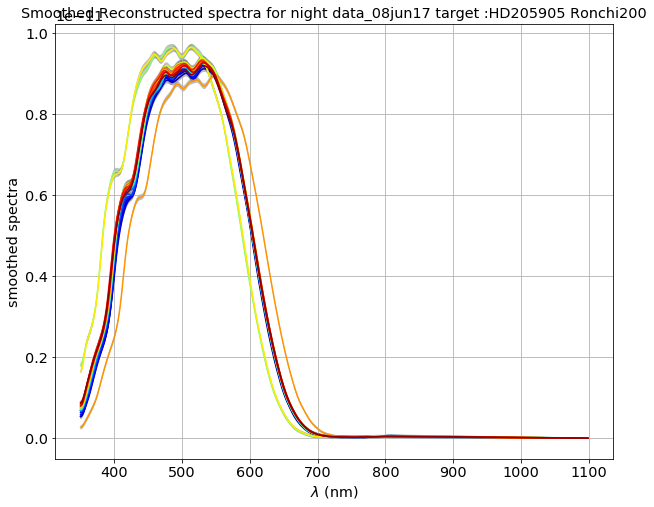

In [80]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron200,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### Thor 300

In [81]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

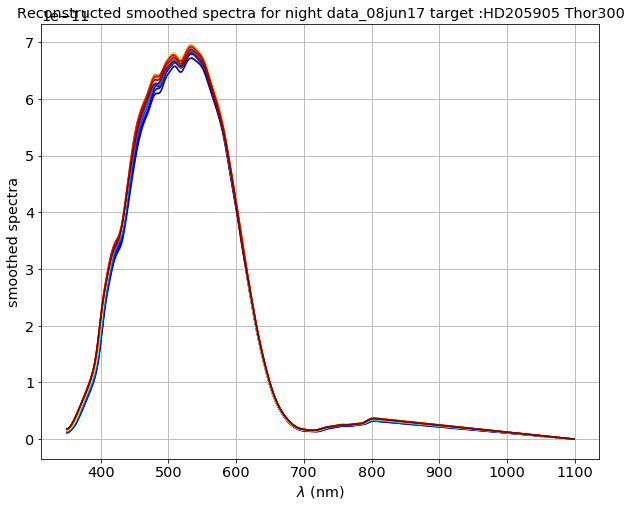

In [82]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhP

In [83]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

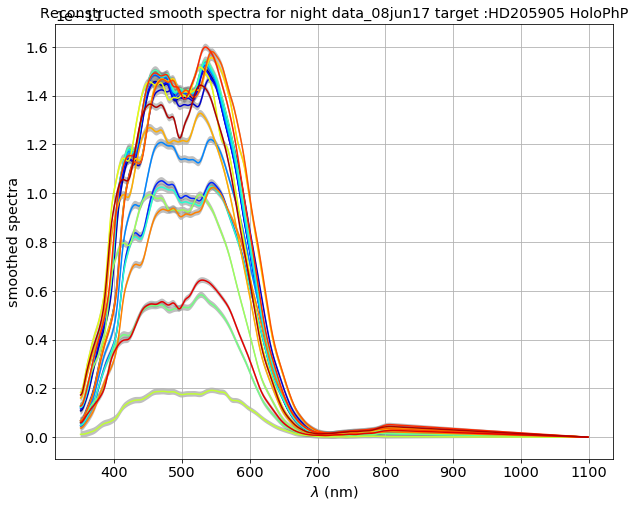

In [84]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloPhAg

In [85]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

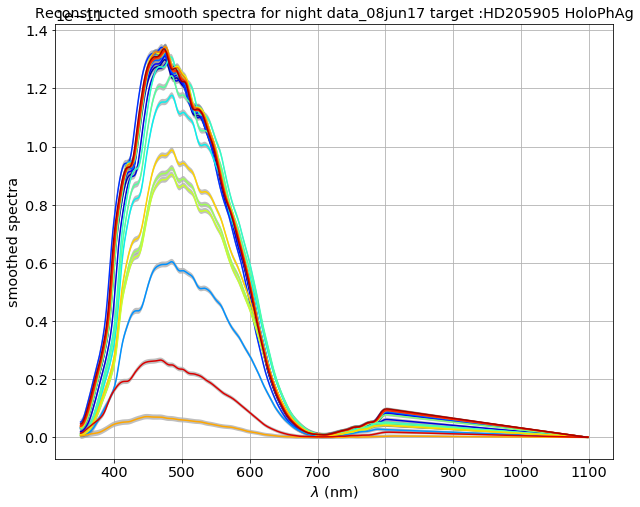

In [86]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

### HoloAmAg

In [87]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

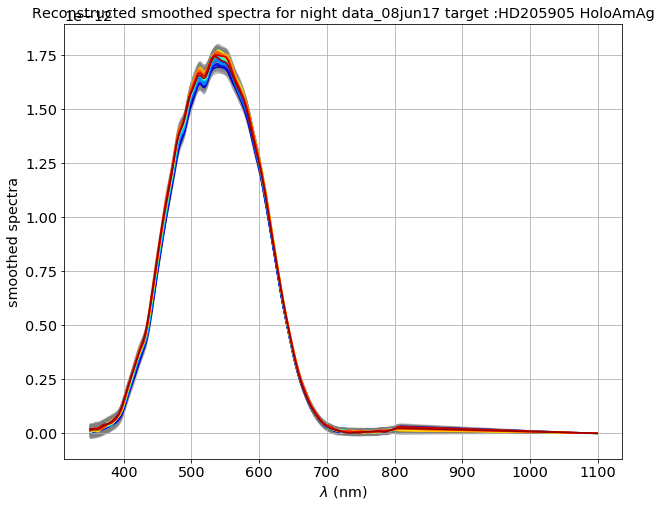

In [88]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True)

## Show the simulated spectra

In [89]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [90]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

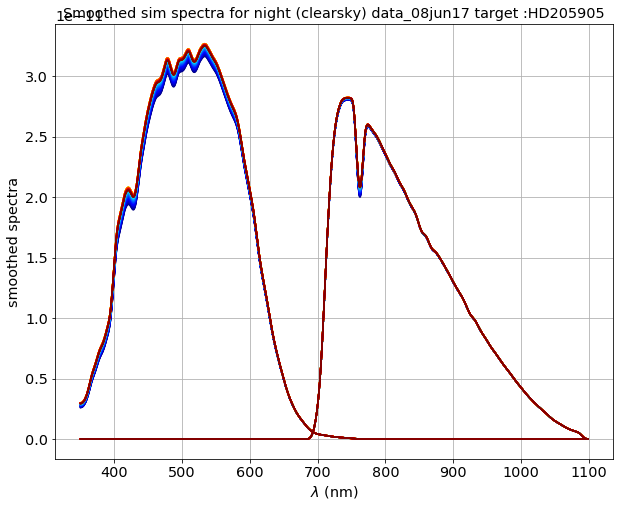

In [91]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### standard sky

In [92]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

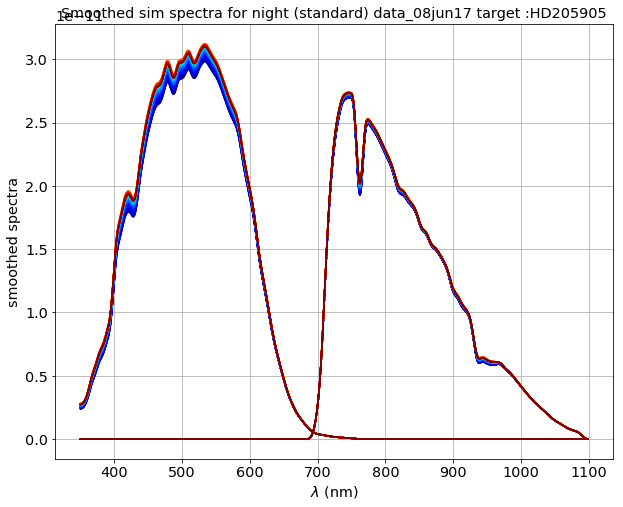

In [93]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

### merra2 sky

In [94]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

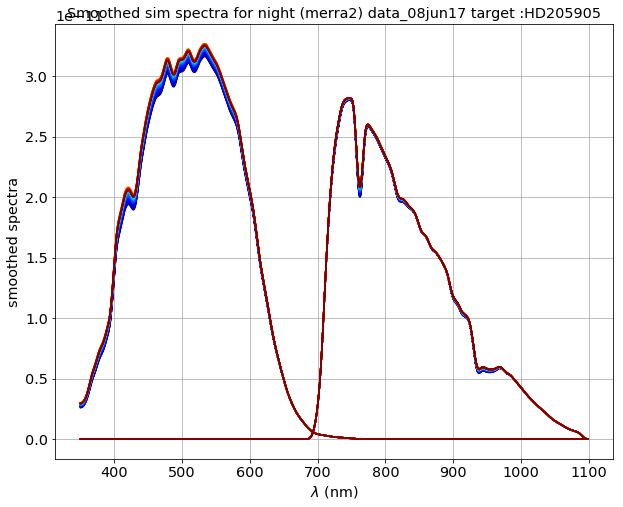

In [95]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False)

# Spectra ratio data/sim

In [96]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

## spectra ratio for Ronchi 200

In [97]:
thetitle="High order contamination for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ron200"

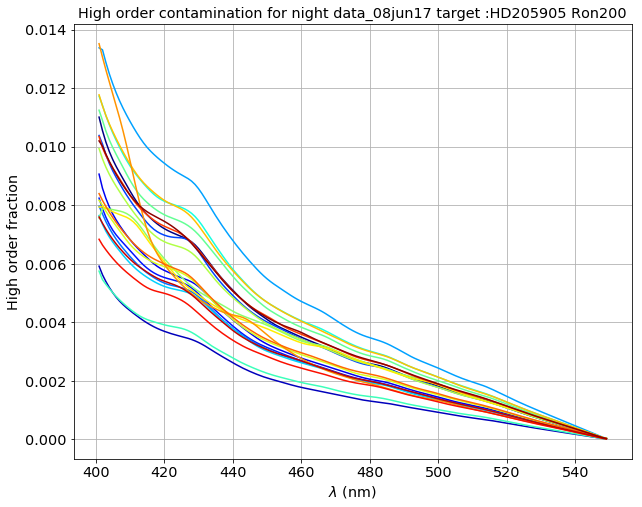

In [98]:
PlotSpectraRatioHighOrderDataSimSmooth(all_spectrafiles,sel_obs_Ron200,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=11)

## High order ratio for Thor300

In [99]:
thetitle="High order contamination for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

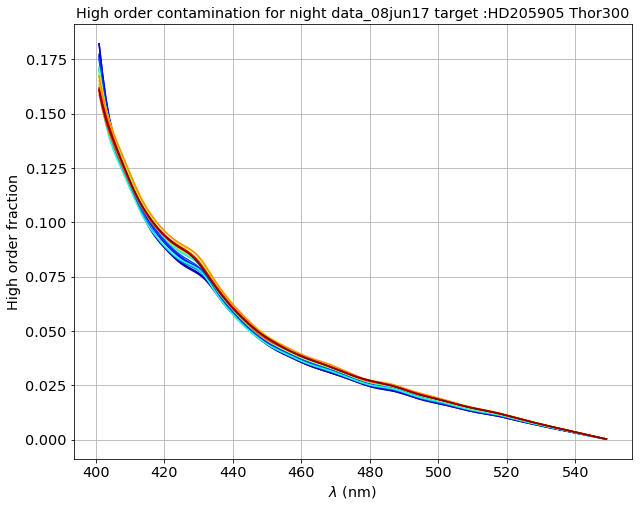

In [100]:
PlotSpectraRatioHighOrderDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=11)

## High order HoloPhP

In [101]:
#thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"
thetitle="High order contamination for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

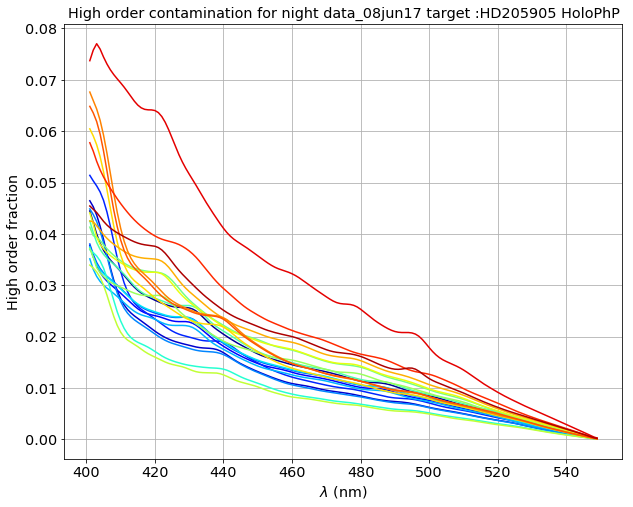

In [102]:
#PlotSpectraRatioDataDivSimSmooth(all_spectrafiles,path_sim1,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,
#                     FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=350,XMAX=650.,YMIN=0,YMAX=0)
PlotSpectraRatioHighOrderDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=11)

## High order ratio for HoloPhAg

In [103]:
#thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"
thetitle="High order contamination for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

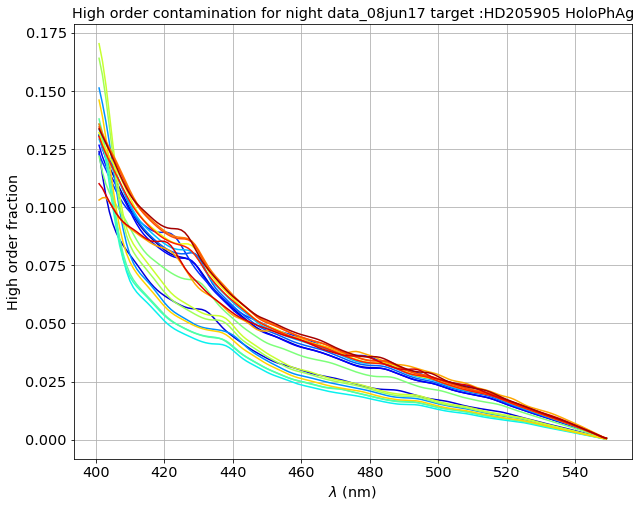

In [104]:
PlotSpectraRatioHighOrderDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=11)

## High order ratio for HoloAmAg

In [105]:
thetitle="High order contamination for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

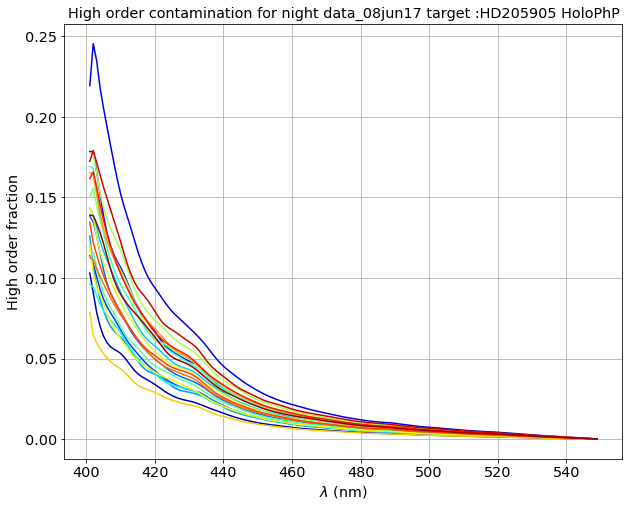

In [106]:
PlotSpectraRatioHighOrderDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=11)